# ANLI with LLM

You have to implement in this notebook a better ANLI classifier using an LLM.
This classifier must be implemented using DSPy.


In [ ]:
# Configure the DSPy environment with the language model - for grok the parameters must be:
# env variable should be in os.environ['XAI_API_KEY']
# "xai/grok-3-mini"
import os
import dspy

os.environ['XAI_API_KEY'] = 'YOUR-API-KEY-HERE'  # Set your API key here

lm = dspy.LM('xai/grok-3-mini', api_key=os.environ['XAI_API_KEY'])
# for ollama 
# lm = dspy.LM('ollama_chat/devstral', api_base='http://localhost:11434', api_key='')
dspy.configure(lm=lm)

## Defining classifiers

In [48]:
from typing import Literal
from sentence_transformers import SentenceTransformer, CrossEncoder
import numpy as np

## Implement the DSPy classifier program.
similarity_model = SentenceTransformer("all-MiniLM-L6-v2")

class NLISignature(dspy.Signature):
    """Natural Language Inference task: Given a premise and hypothesis, classify the relationship and provide explanation."""
    premise = dspy.InputField(desc="The premise statement")
    hypothesis = dspy.InputField(desc="The hypothesis statement")
    explanation = dspy.OutputField(desc="Explanation of the relationship between premise and hypothesis")
    label = dspy.OutputField(desc="Classification: entailment, contradiction, or neutral")

class NLIExplanationSignature(dspy.Signature):
    """Generate explanation for Natural Language Inference."""
    premise = dspy.InputField(desc="The premise statement")
    hypothesis = dspy.InputField(desc="The hypothesis statement")
    explanation = dspy.OutputField(desc="Explanation of the relationship between premise and hypothesis")

class NLILabelSignature(dspy.Signature):
    """Classify Natural Language Inference given explanation."""
    premise = dspy.InputField(desc="The premise statement")
    hypothesis = dspy.InputField(desc="The hypothesis statement")
    explanation = dspy.InputField(desc="Explanation of the relationship")
    label = dspy.OutputField(desc="Classification: entailment, contradiction, or neutral")

class JointNLIClassifier(dspy.Module):
    """Joint prompt approach: generate explanation and label together."""
    
    def __init__(self):
        super().__init__()
        self.classifier = dspy.ChainOfThought(NLISignature)
    
    def forward(self, premise, hypothesis):
        result = self.classifier(premise=premise, hypothesis=hypothesis)
        return dspy.Prediction(
            explanation=result.explanation,
            label=result.label
        )

class PipelineNLIClassifier(dspy.Module):
    """Pipeline approach: generate explanation first, then label."""
    
    def __init__(self):
        super().__init__()
        self.explainer = dspy.ChainOfThought(NLIExplanationSignature)
        self.classifier = dspy.ChainOfThought(NLILabelSignature)
    
    def forward(self, premise, hypothesis):
        # First generate explanation
        explanation_result = self.explainer(premise=premise, hypothesis=hypothesis)
        
        # Then classify using the explanation
        label_result = self.classifier(
            premise=premise, 
            hypothesis=hypothesis, 
            explanation=explanation_result.explanation
        )
        
        return dspy.Prediction(
            explanation=explanation_result.explanation,
            label=label_result.label
        )

class RefinedNLIClassifier(dspy.Module):
    """Refined classifier that uses similarity metrics to improve explanations."""
    
    def __init__(self, base_classifier, similarity_threshold=0.7, max_attempts=3, use_human_reason=True):
        super().__init__()
        self.base_classifier = base_classifier
        self.similarity_threshold = similarity_threshold
        self.max_attempts = max_attempts
        self.use_human_reason = use_human_reason
        # Initialize the refiner module
        self.refiner = dspy.ChainOfThought(NLISignature)
    
    def calculate_similarity(self, premise, hypothesis, explanation):
        """Calculate similarity between explanation and (premise, hypothesis)."""
        premise_hyp_text = f"{premise} {hypothesis}"
        embeddings = similarity_model.encode([premise_hyp_text, explanation])
        similarity = similarity_model.similarity(embeddings, embeddings)[0][1].item()
        return similarity
    
    def calculate_similarity_to_human(self, predicted_explanation, human_reason):
        """Calculate similarity between predicted explanation and human reason."""
        if not human_reason:
            return 0.0
        embeddings = similarity_model.encode([predicted_explanation, human_reason])
        similarity = similarity_model.similarity(embeddings, embeddings)[0][1].item()
        return similarity
    
    def get_combined_score(self, explanation, premise, hypothesis, human_reason):
        """Calculate combined similarity score."""
        premise_hyp_similarity = self.calculate_similarity(premise, hypothesis, explanation)
        
        if self.use_human_reason and human_reason:
            human_similarity = self.calculate_similarity_to_human(explanation, human_reason)
            # Weighted combination: 60% human similarity + 40% premise-hypothesis similarity
            return 0.6 * human_similarity + 0.4 * premise_hyp_similarity
        else:
            return premise_hyp_similarity
    
    def forward(self, premise, hypothesis, human_reason=None):
        # Get initial prediction
        initial_pred = self.base_classifier(premise=premise, hypothesis=hypothesis)
        
        current_explanation = initial_pred.explanation
        current_label = initial_pred.label
        
        # Calculate initial score
        initial_score = self.get_combined_score(current_explanation, premise, hypothesis, human_reason)
        current_score = initial_score
        
        attempt = 0
        refinement_history = []
        was_refined = False
        
        # Try refinement if score is below threshold
        while attempt < self.max_attempts and current_score < self.similarity_threshold:
            attempt += 1
            
            try:
                # Try to get a better explanation
                refined_pred = self.refiner(
                    premise=premise,
                    hypothesis=hypothesis
                )
                
                # Calculate new score
                new_score = self.get_combined_score(refined_pred.explanation, premise, hypothesis, human_reason)
                
                # Store refinement attempt
                refinement_history.append({
                    'attempt': attempt,
                    'explanation': refined_pred.explanation,
                    'label': refined_pred.label,
                    'score': new_score,
                    'premise_hyp_similarity': self.calculate_similarity(premise, hypothesis, refined_pred.explanation),
                    'human_similarity': self.calculate_similarity_to_human(refined_pred.explanation, human_reason) if human_reason else None
                })
                
                # Use the better explanation if it improves the score
                if new_score > current_score:
                    current_explanation = refined_pred.explanation
                    current_label = refined_pred.label
                    current_score = new_score
                    was_refined = True
                    
                    if current_score >= self.similarity_threshold:
                        break

            except Exception as e:
                print(f"  Refinement attempt {attempt} failed: {e}")
                refinement_history.append({
                    'attempt': attempt,
                    'error': str(e),
                    'score': None
                })
                continue
        
        # Calculate final similarities for tracking
        final_premise_hyp_similarity = self.calculate_similarity(premise, hypothesis, current_explanation)
        final_human_similarity = self.calculate_similarity_to_human(current_explanation, human_reason) if human_reason else None
        
        return dspy.Prediction(
            explanation=current_explanation,
            label=current_label,
            similarity_score=final_premise_hyp_similarity,
            human_similarity_score=final_human_similarity,
            combined_score=current_score,
            was_refined=was_refined,
            refinement_attempts=attempt,
            initial_score=initial_score,
            refinement_history=refinement_history,
            threshold_reached=current_score >= self.similarity_threshold
        )
            
            
# Initialize classifiers
joint_classifier = JointNLIClassifier()
pipeline_classifier = PipelineNLIClassifier()
refined_joint_classifier = RefinedNLIClassifier(joint_classifier)
refined_pipeline_classifier = RefinedNLIClassifier(pipeline_classifier)


### Evaluation functions for model labeling and their explanations

In [67]:
def evaluate_explanation_quality(premise, hypothesis, predicted_explanation, human_reason=None):
    """Evaluate the quality of predicted explanation using similarity metrics."""
    premise_hyp_text = f"{premise} {hypothesis}"
    
    similarities = {}
    
    # Similarity between predicted explanation and (premise, hypothesis)
    embeddings_pred = similarity_model.encode([premise_hyp_text, predicted_explanation])
    similarities['pred_vs_premise_hyp'] = similarity_model.similarity(
        embeddings_pred, embeddings_pred
    )[0][1].item()
    
    if human_reason:
        # Similarity between predicted explanation and human reason
        embeddings_human = similarity_model.encode([predicted_explanation, human_reason])
        similarities['pred_vs_human'] = similarity_model.similarity(
            embeddings_human, embeddings_human
        )[0][1].item()
        
        # Similarity between (premise, hypothesis) and human reason
        embeddings_baseline = similarity_model.encode([premise_hyp_text, human_reason])
        similarities['premise_hyp_vs_human'] = similarity_model.similarity(
            embeddings_baseline, embeddings_baseline
        )[0][1].item()
    
    return similarities

def normalize_label(label):
    """Normalize label to standard format."""
    if isinstance(label, str):
        label = label.lower().strip()
        if label in ['entailment', 'entails', 'e']:
            return 'entailment'
        elif label in ['contradiction', 'contradicts', 'c']:
            return 'contradiction'
        elif label in ['neutral', 'n']:
            return 'neutral'
    elif isinstance(label, int):
        if label == 0:
            return 'entailment'
        elif label == 1:
            return 'neutral'
        elif label == 2:
            return 'contradiction'
    return str(label)

In [39]:
import pandas as pd
from tqdm import tqdm
import json

def evaluate_model(model, dataset_split, model_name, max_samples=300):
    """Evaluate a model on a dataset split - returns only results without computing metrics."""
    results = []
    predictions = []
    ground_truth = []
    explanation_qualities = []
    
    print(f"Evaluating {model_name} on {max_samples} samples...")
    
    for i, sample in enumerate(tqdm(dataset_split, desc=f"Processing {model_name}")):
        if i >= max_samples:
            break
        try:
            if hasattr(model, 'base_classifier'):  # RefinedNLIClassifier
                pred = model(
                    premise=sample['premise'],
                    hypothesis=sample['hypothesis'],
                    human_reason=sample.get('reason')
                )
            else:  #JointNLIClassifier or PipelineNLIClassifier
                pred = model(
                    premise=sample['premise'],
                    hypothesis=sample['hypothesis']
                )
            
            pred_label = normalize_label(pred.label)
            true_label = normalize_label(sample['label'])
            
            explanation_quality = evaluate_explanation_quality(
                sample['premise'],
                sample['hypothesis'],
                pred.explanation,
                sample.get('reason')
            )
            
            results.append({
                'premise': sample['premise'],
                'hypothesis': sample['hypothesis'],
                'true_label': true_label,
                'pred_label': pred_label,
                'predicted_explanation': pred.explanation,
                'human_reason': sample.get('reason'),
                'explanation_quality': explanation_quality,
                'similarity_score': getattr(pred, 'similarity_score', None),
                'was_refined': getattr(pred, 'was_refined', False)
            })
            
            predictions.append(pred_label)
            ground_truth.append(true_label)
            explanation_qualities.append(explanation_quality)
            
        except Exception as e:
            print(f"Error processing sample {i}: {e}")
            continue
    
    return {
        'model_name': model_name,
        'results': results,
        'predictions': predictions,
        'ground_truth': ground_truth,
        'explanation_qualities': explanation_qualities
    }

Note: We've used 300 samples of the dev_r3 section, Evaluating more samples can take some time.

In [84]:
def evaluate_deberta_model(test_data, max_samples=300):
    """Evaluate the DeBERTa model on test examples"""
    predictions = []
    references = []
    
    print(f"Evaluating DeBERTa on {len(test_data)} examples...")
    
    for i, example in enumerate(tqdm(test_data, desc="DeBERTa Evaluation")):
        if i >= max_samples:
            break   
        try:
            pred_label = deberta_predict(example['premise'], example['hypothesis'])
            predictions.append(pred_label)
            references.append(example['label'])
        except Exception as e:
            print(f"Error processing example {i}: {e}")
            # Use neutral as default prediction in case of error
            predictions.append(1)
            references.append(example['label'])
    
    return predictions, references

## Running evaluation

Make sure you load the ANLI dataset before running the following cells.

In [28]:
dev_r3_data = dataset['dev_r3']

In [37]:
dev_r3_data

Dataset({
    features: ['uid', 'premise', 'hypothesis', 'label', 'reason'],
    num_rows: 1200
})

### Joint NLI Classifier

In [ ]:
print("\n" + "="*60)
print("EVALUATING JOINT CLASSIFIER")
print("="*60)
joint_results = evaluate_model(joint_classifier, dev_r3_data, "Joint NLI Classifier")

### Pipeline NLI Classifier

In [ ]:
print("\n" + "="*60)
print("EVALUATING PIPELINE CLASSIFIER")
print("="*60)
pipeline_results = evaluate_model(pipeline_classifier, dev_r3_data, "Pipeline NLI Classifier")

### Refined Joint NLI Classifier

In [ ]:
print("\n" + "="*60)
print("EVALUATING REFINED JOINT CLASSIFIER")
print("="*60)
refined_joint_results = evaluate_model(refined_joint_classifier, dev_r3_data, "Refined Joint NLI Classifier")

### Refined Pipeline NLI Classifier

In [ ]:
print("\n" + "="*60)
print("EVALUATING REFINED JOINT CLASSIFIER")
print("="*60)
refined_pipeline_results = evaluate_model(refined_pipeline_classifier, dev_r3_data, "Refined Pipeline NLI Classifier")

### DeBERTa Model

In [ ]:
print(f"\n--- DeBERTa Evaluation on test_r3 ---")
deberta_predictions, _ = evaluate_deberta_model(dev_r3_data)

## Load ANLI dataset

In [41]:
from datasets import load_dataset

dataset = load_dataset("facebook/anli")
dataset = dataset.filter(lambda x: x['reason'] != None and x['reason'] != "")

In [83]:
# Load DeBERTa baseline model
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_name = "MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
deberta_model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

def deberta_predict(premise, hypothesis):
    """Predict using DeBERTa model"""
    input_tokens = tokenizer(premise, hypothesis, truncation=True, return_tensors="pt")
    input_tokens = {k: v.to(device) for k, v in input_tokens.items()}
    
    with torch.no_grad():
        output = deberta_model(**input_tokens)
        prediction = torch.softmax(output.logits[0], -1).tolist()
    
    # Return the predicted label (0=entailment, 1=neutral, 2=contradiction)
    return prediction.index(max(prediction))

print("DeBERTa model loaded successfully!")

DeBERTa model loaded successfully!


## Evaluate Metrics

Let's use the huggingface `evaluate` package to compute the performance of the baseline.


In [42]:
from evaluate import load

accuracy = load("accuracy")
precision = load("precision")
recall = load("recall")
f1 = load("f1")


In [43]:
import evaluate
clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

## Your Turn

Compute the classification metrics on the baseline LLM model on each test section of the ANLI dataset for samples that have a non-empty 'reason' field.

You also must show a comparison between the DeBERTa baseline model and this LLM baseline model. The comparison metric should compute the agreement between the two models:
* On how many samples they are both correct [Correct]
* On how many samples Model1 is correct and Model2 is incorrect [Correct1]
* On how many samples Model1 is incorrect and Model2 is correct [Correct2]
* On how many samples both are incorrect [Incorrect]

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def create_label_mapping():
    """Create mapping between string labels and numeric labels."""
    label_to_id = {'entailment': 0, 'neutral': 1, 'contradiction': 2}
    id_to_label = {0: 'entailment', 1: 'neutral', 2: 'contradiction'}
    return label_to_id, id_to_label

def normalize_and_convert_labels(labels, target_format='string'):
    """Normalize labels and convert to target format (string or numeric)."""
    normalized = []
    
    for label in labels:
        if isinstance(label, int):
            # Convert integer to string first
            if label == 0:
                norm_label = 'entailment'
            elif label == 1:
                norm_label = 'neutral' 
            elif label == 2:
                norm_label = 'contradiction'
            else:
                norm_label = str(label)
        elif isinstance(label, str):
            # Normalize string labels
            label = label.lower().strip()
            if label in ['entailment', 'entails', 'e']:
                norm_label = 'entailment'
            elif label in ['contradiction', 'contradicts', 'c']:
                norm_label = 'contradiction'
            elif label in ['neutral', 'n']:
                norm_label = 'neutral'
            else:
                norm_label = label
        else:
            norm_label = str(label)
        
        if target_format == 'numeric':
            # Convert to numeric
            if norm_label == 'entailment':
                normalized.append(0)
            elif norm_label == 'neutral':
                normalized.append(1)
            elif norm_label == 'contradiction':
                normalized.append(2)
            else:
                normalized.append(-1)
        else:
            normalized.append(norm_label)
    
    return normalized

def compute_classification_metrics_safe(predictions, references):
    """Compute classification metrics with proper label handling."""
    # Normalize both to strings first, then convert to numeric
    norm_predictions = normalize_and_convert_labels(predictions, 'string')
    norm_references = normalize_and_convert_labels(references, 'string')
    
    # Convert to numeric
    numeric_predictions = normalize_and_convert_labels(norm_predictions, 'numeric')
    numeric_references = normalize_and_convert_labels(norm_references, 'numeric')
    
    # Filter out invalid labels
    valid_indices = [i for i, (p, r) in enumerate(zip(numeric_predictions, numeric_references)) if p != -1 and r != -1]
    
    if not valid_indices:
        return {'accuracy': 0.0, 'f1': 0.0, 'precision': 0.0, 'recall': 0.0}
    
    filtered_predictions = [numeric_predictions[i] for i in valid_indices]
    filtered_references = [numeric_references[i] for i in valid_indices]
    
    metrics = {}
    
    try:
        metrics['accuracy'] = accuracy.compute(predictions=filtered_predictions, references=filtered_references)['accuracy']
        metrics['f1'] = f1.compute(predictions=filtered_predictions, references=filtered_references, average='weighted')['f1']
        metrics['precision'] = precision.compute(predictions=filtered_predictions, references=filtered_references, average='weighted')['precision']
        metrics['recall'] = recall.compute(predictions=filtered_predictions, references=filtered_references, average='weighted')['recall']
    except Exception as e:
        print(f"Error computing metrics: {e}")
        return {'accuracy': 0.0, 'f1': 0.0, 'precision': 0.0, 'recall': 0.0}
    
    return metrics

RUNNING COMPREHENSIVE ANALYSIS (INCLUDING DEBERTA)
Results loaded successfully:
  Joint: 300 predictions
  Pipeline: 300 predictions
  Refined Joint: 300 predictions
  Refined Pipeline: 300 predictions
  DeBERTa: 300 predictions

CLASSIFICATION PERFORMANCE COMPARISON (ALL MODELS)

Processing Joint...
  Sample predictions: ['entailment', 'neutral', 'entailment']
  Sample ground truth: [0, 0, 0]
  Computed metrics: {'accuracy': 0.6933333333333334, 'f1': 0.6976957604861698, 'precision': 0.7304938756443863, 'recall': 0.6933333333333334}

Processing Pipeline...
  Sample predictions: ['entailment', 'entailment', 'entailment']
  Sample ground truth: [0, 0, 0]
  Computed metrics: {'accuracy': 0.7133333333333334, 'f1': 0.7163882084458681, 'precision': 0.7314697815652855, 'recall': 0.7133333333333334}

Processing Refined Joint...
  Sample predictions: ['entailment', 'neutral', 'entailment']
  Sample ground truth: [0, 0, 0]
  Computed metrics: {'accuracy': 0.6933333333333334, 'f1': 0.697695760486

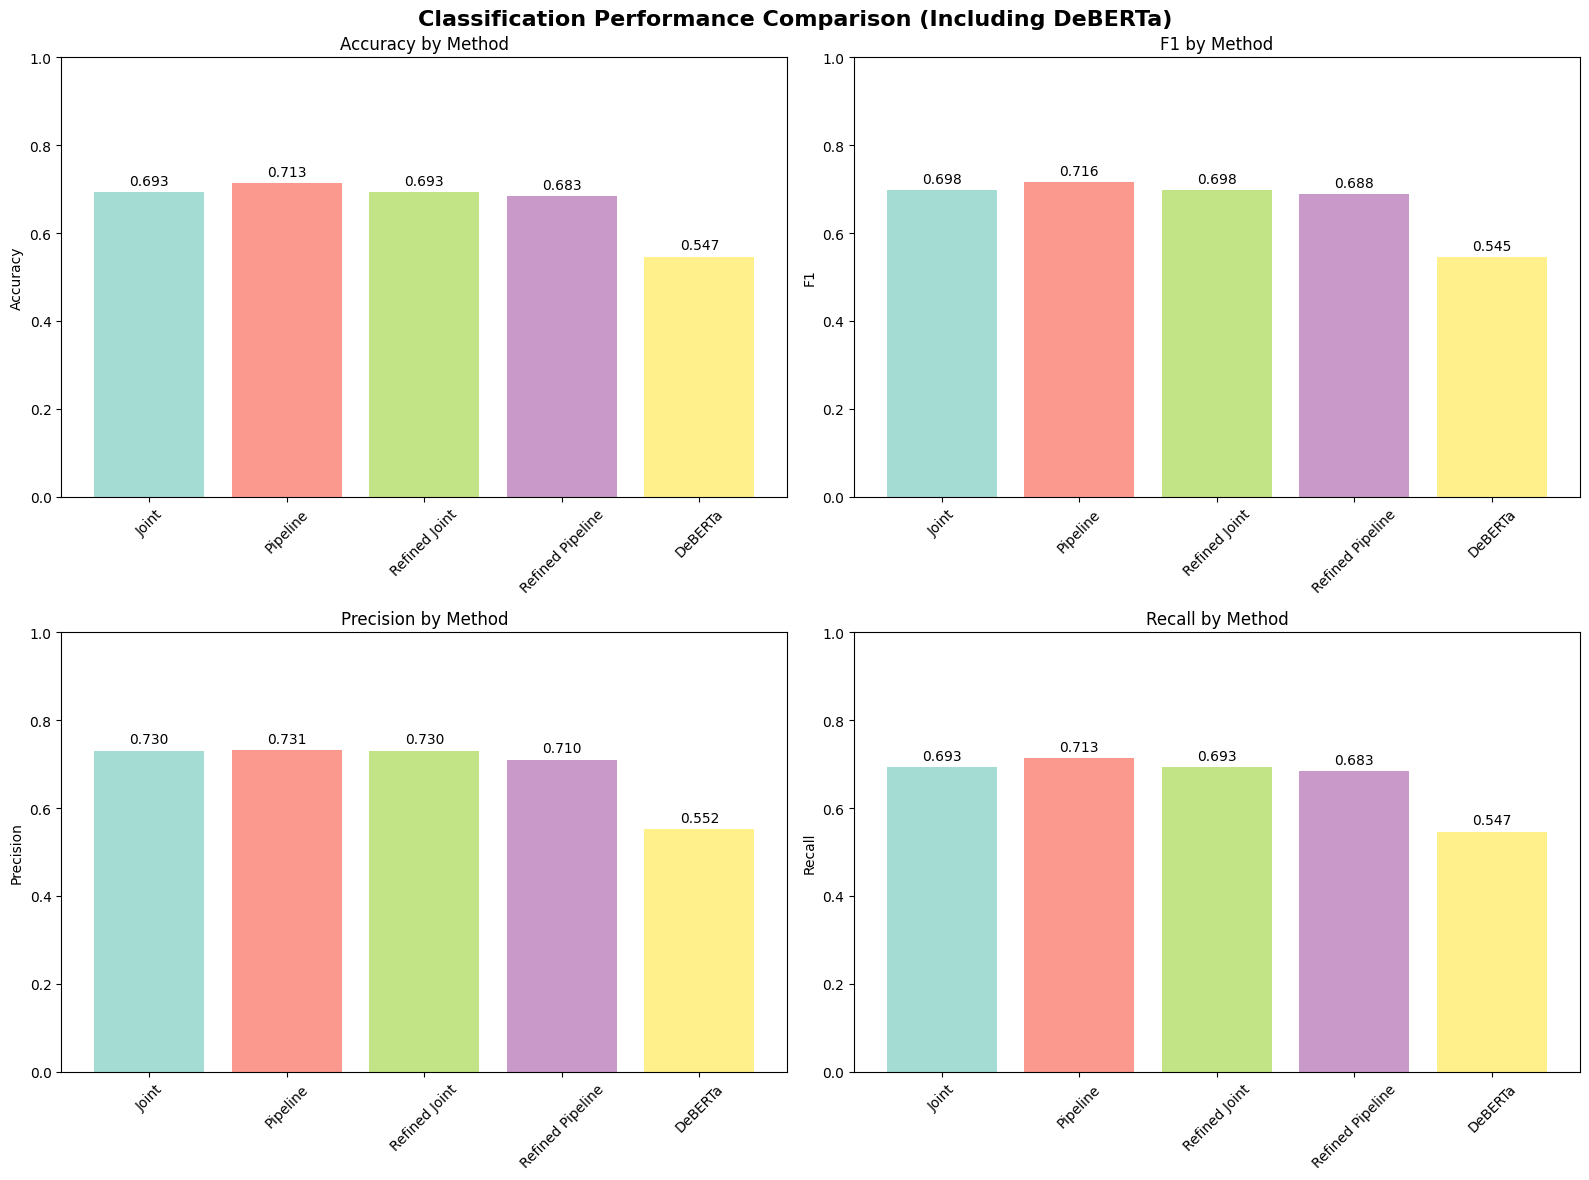


CONFUSION MATRICES COMPARISON (ALL MODELS)


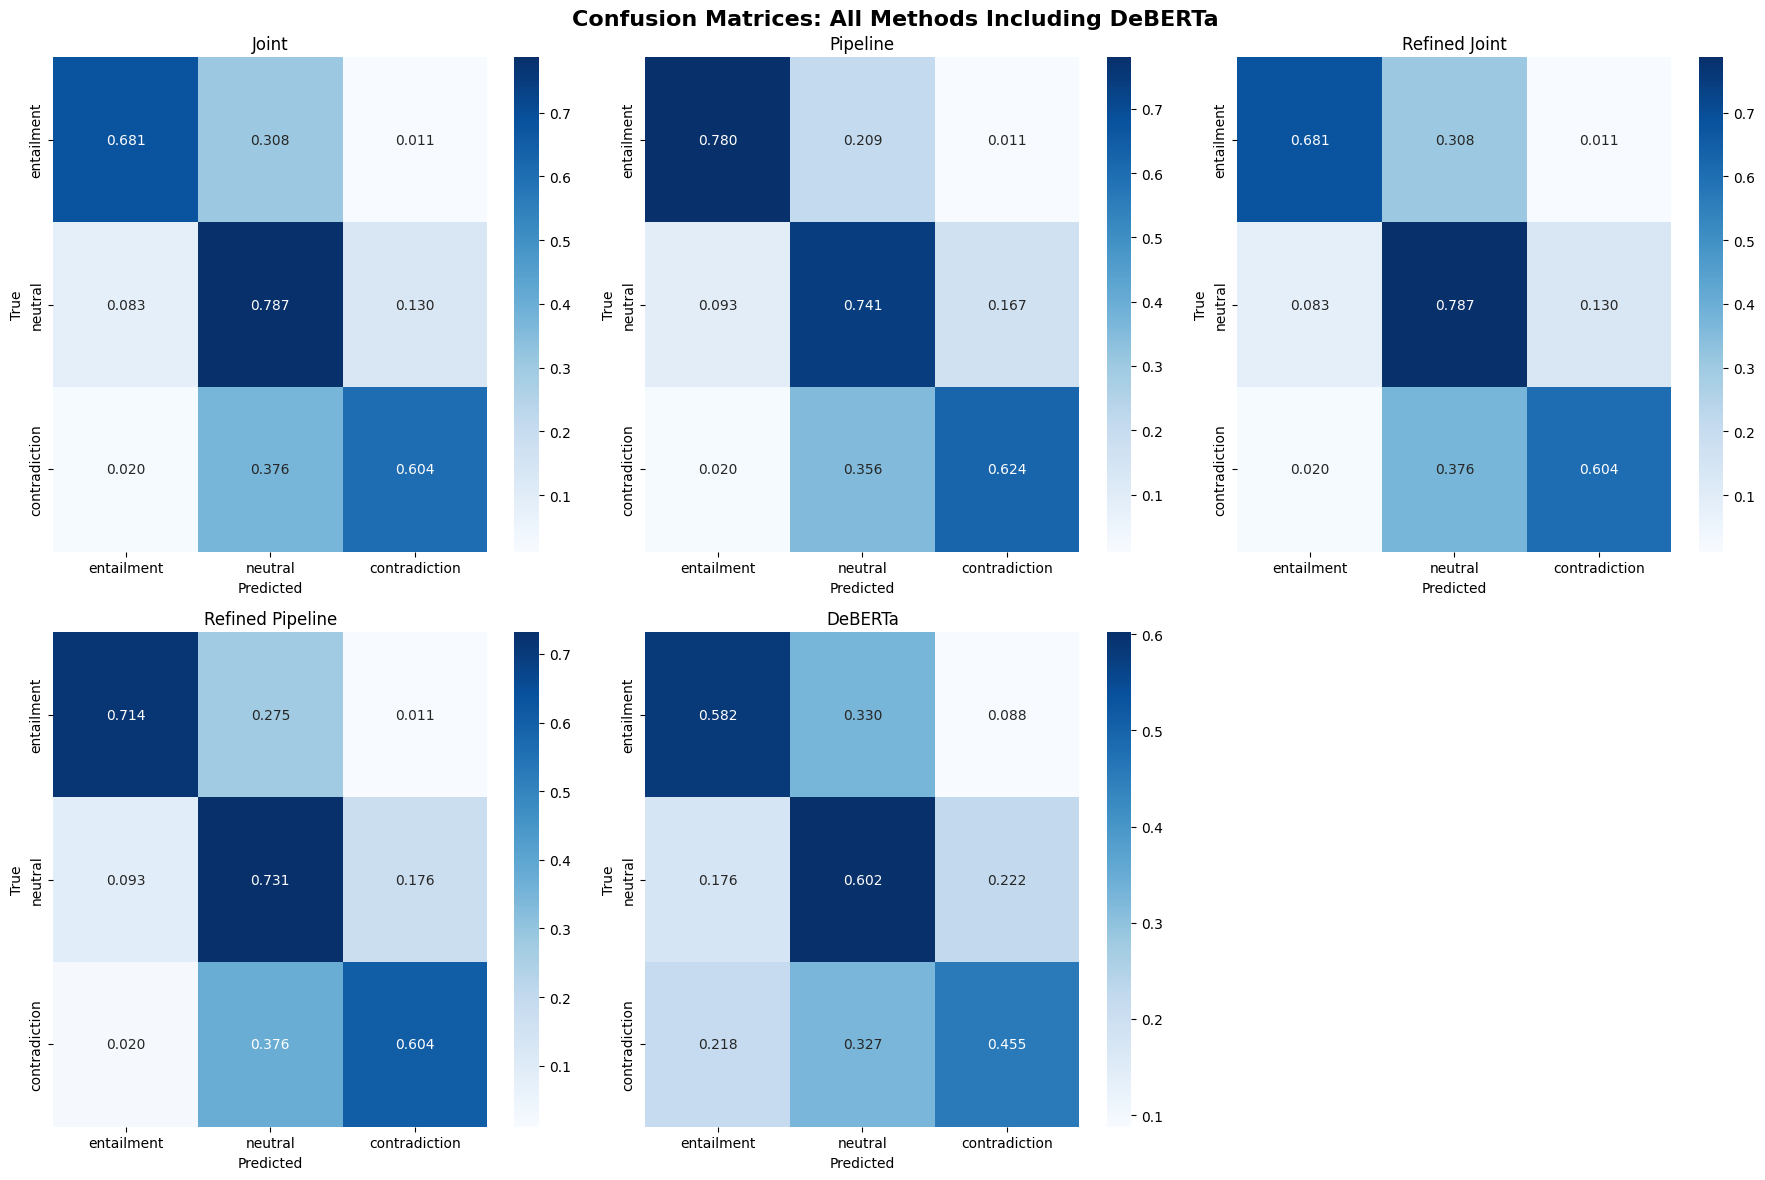


PAIRWISE AGREEMENT ANALYSIS (INCLUDING DEBERTA)

Joint vs Pipeline Agreement Analysis (Total samples: 300):
  Both Correct: 191 (63.67%)
  Joint Only Correct: 17 (5.67%)
  Pipeline Only Correct: 23 (7.67%)
  Both Incorrect: 69 (23.00%)


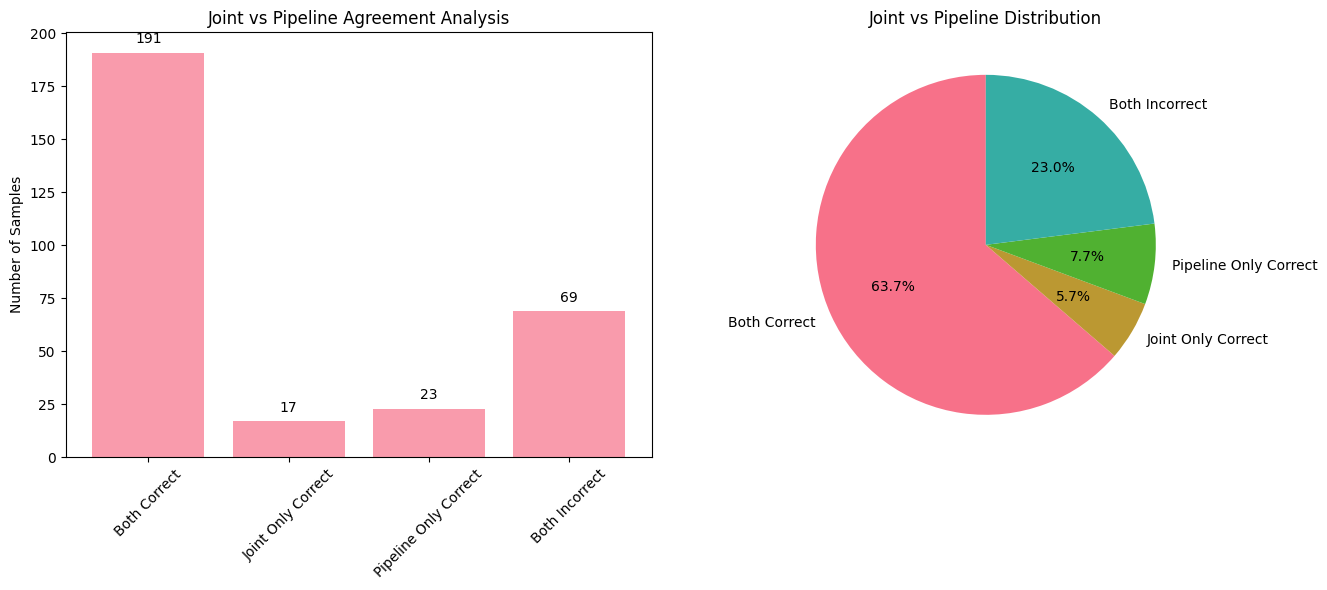


Joint vs Refined Joint Agreement Analysis (Total samples: 300):
  Both Correct: 208 (69.33%)
  Joint Only Correct: 0 (0.00%)
  Refined Joint Only Correct: 0 (0.00%)
  Both Incorrect: 92 (30.67%)


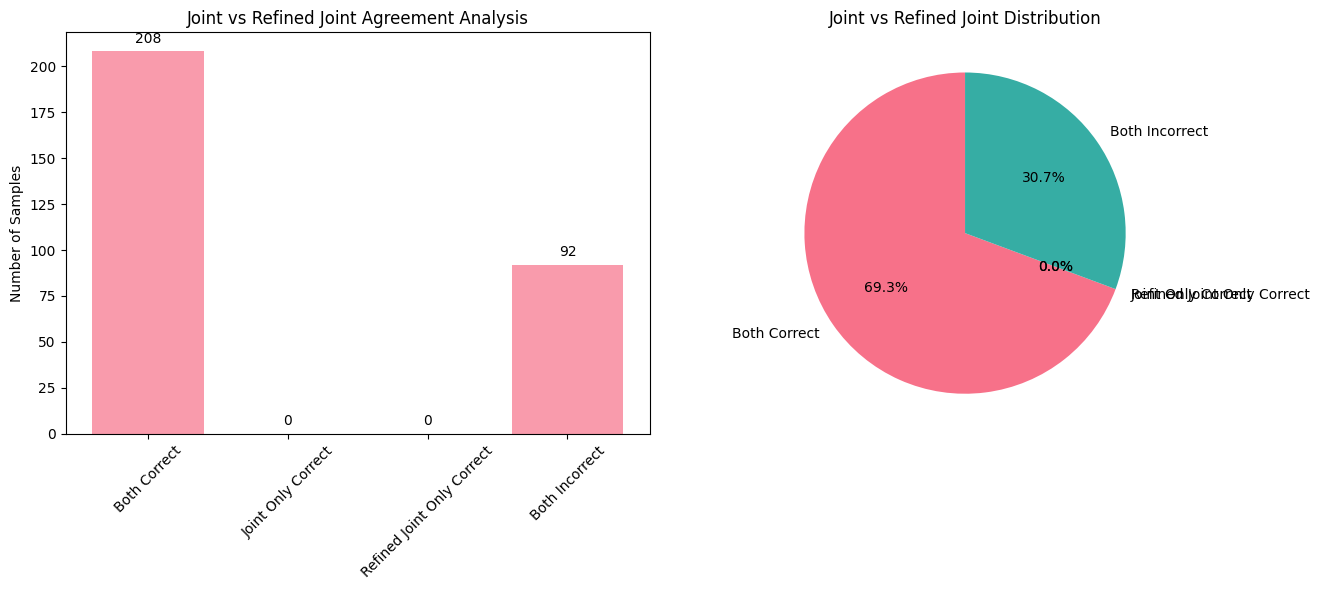


Joint vs Refined Pipeline Agreement Analysis (Total samples: 300):
  Both Correct: 195 (65.00%)
  Joint Only Correct: 13 (4.33%)
  Refined Pipeline Only Correct: 10 (3.33%)
  Both Incorrect: 82 (27.33%)


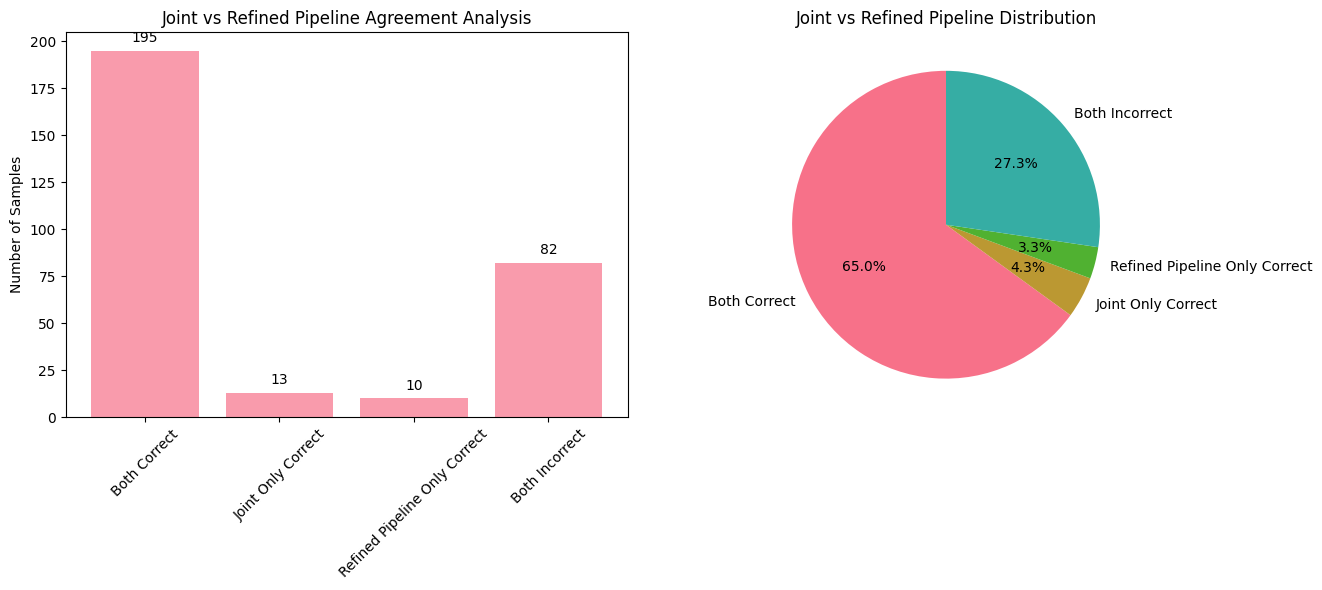


Joint vs DeBERTa Agreement Analysis (Total samples: 300):
  Both Correct: 132 (44.00%)
  Joint Only Correct: 76 (25.33%)
  DeBERTa Only Correct: 32 (10.67%)
  Both Incorrect: 60 (20.00%)


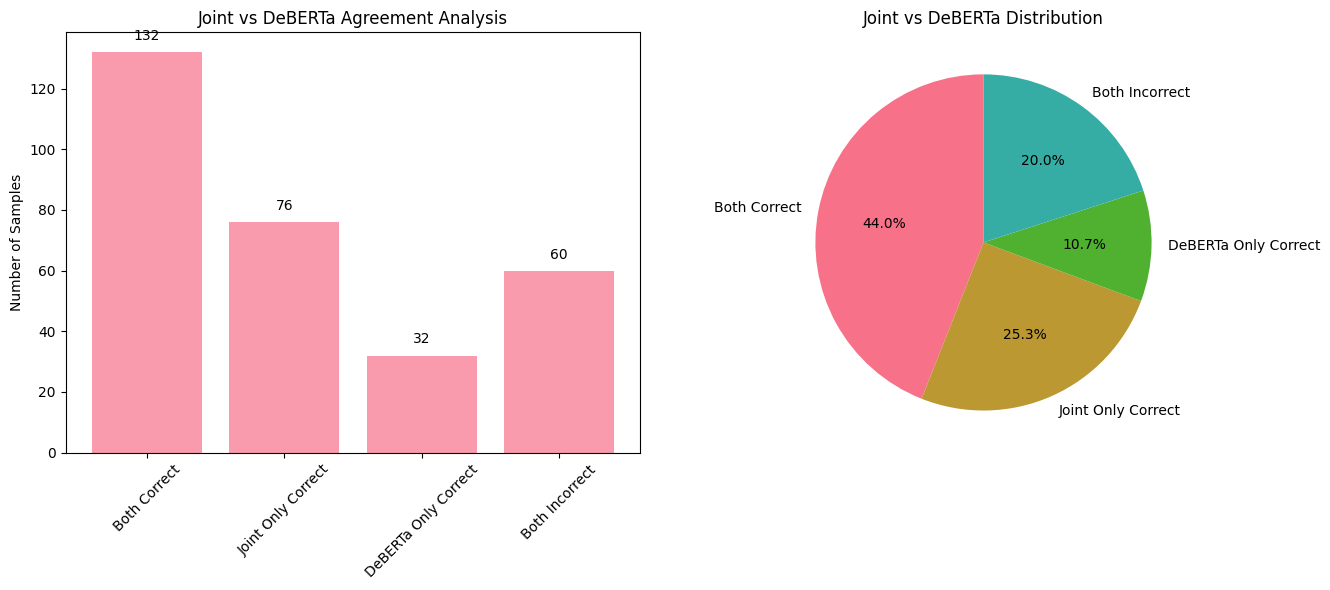


Pipeline vs Refined Joint Agreement Analysis (Total samples: 300):
  Both Correct: 191 (63.67%)
  Pipeline Only Correct: 23 (7.67%)
  Refined Joint Only Correct: 17 (5.67%)
  Both Incorrect: 69 (23.00%)


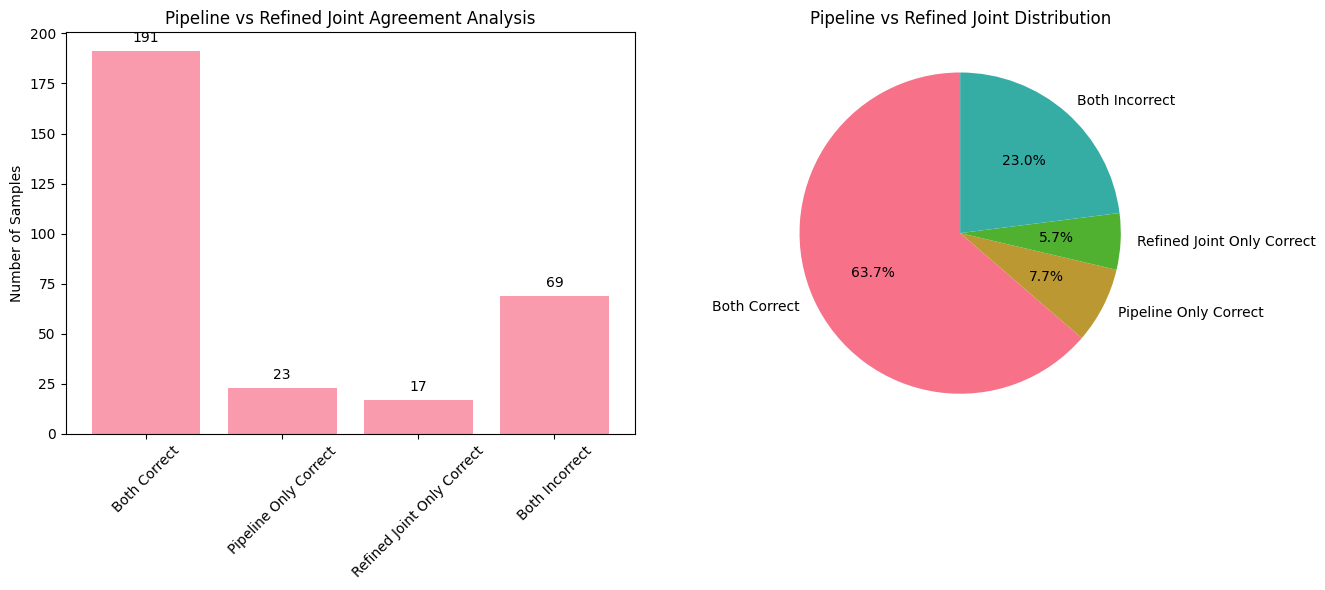


Pipeline vs Refined Pipeline Agreement Analysis (Total samples: 300):
  Both Correct: 201 (67.00%)
  Pipeline Only Correct: 13 (4.33%)
  Refined Pipeline Only Correct: 4 (1.33%)
  Both Incorrect: 82 (27.33%)


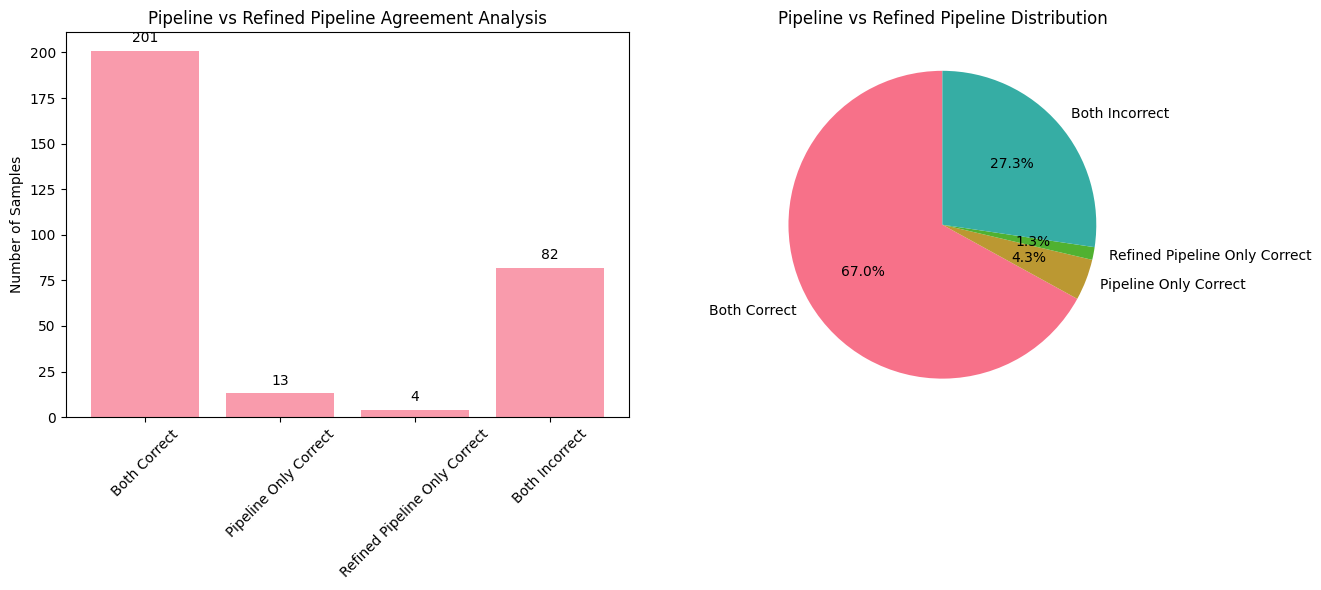


Pipeline vs DeBERTa Agreement Analysis (Total samples: 300):
  Both Correct: 130 (43.33%)
  Pipeline Only Correct: 84 (28.00%)
  DeBERTa Only Correct: 34 (11.33%)
  Both Incorrect: 52 (17.33%)


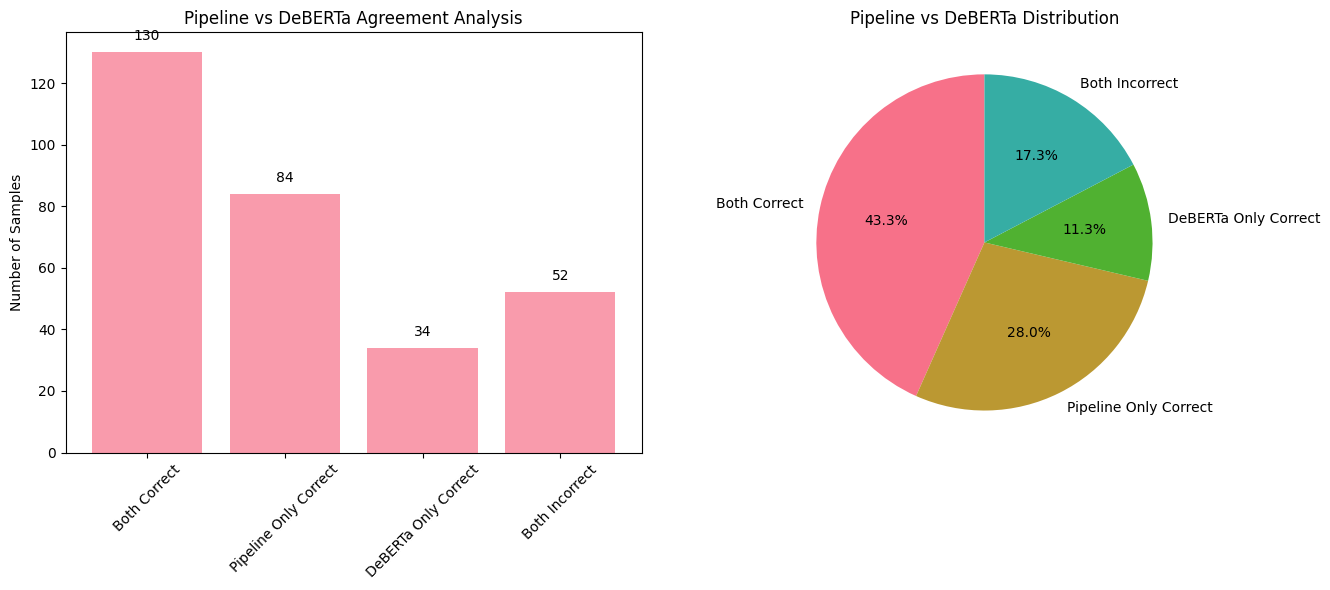


Refined Joint vs Refined Pipeline Agreement Analysis (Total samples: 300):
  Both Correct: 195 (65.00%)
  Refined Joint Only Correct: 13 (4.33%)
  Refined Pipeline Only Correct: 10 (3.33%)
  Both Incorrect: 82 (27.33%)


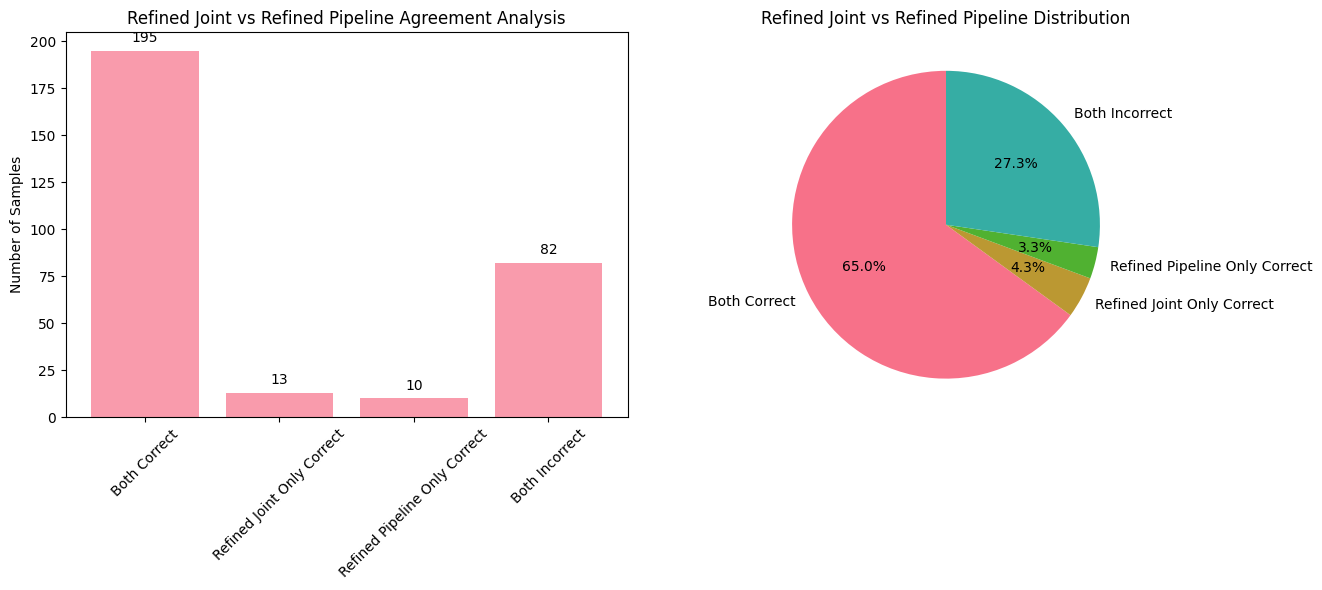


Refined Joint vs DeBERTa Agreement Analysis (Total samples: 300):
  Both Correct: 132 (44.00%)
  Refined Joint Only Correct: 76 (25.33%)
  DeBERTa Only Correct: 32 (10.67%)
  Both Incorrect: 60 (20.00%)


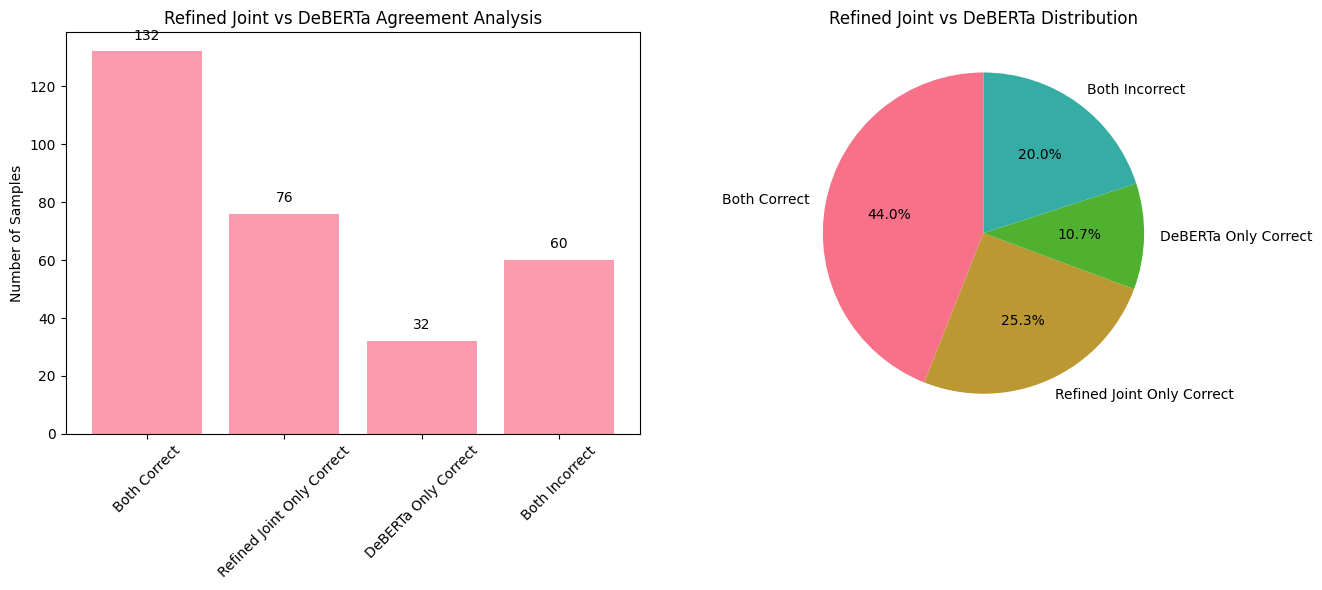


Refined Pipeline vs DeBERTa Agreement Analysis (Total samples: 300):
  Both Correct: 127 (42.33%)
  Refined Pipeline Only Correct: 78 (26.00%)
  DeBERTa Only Correct: 37 (12.33%)
  Both Incorrect: 58 (19.33%)


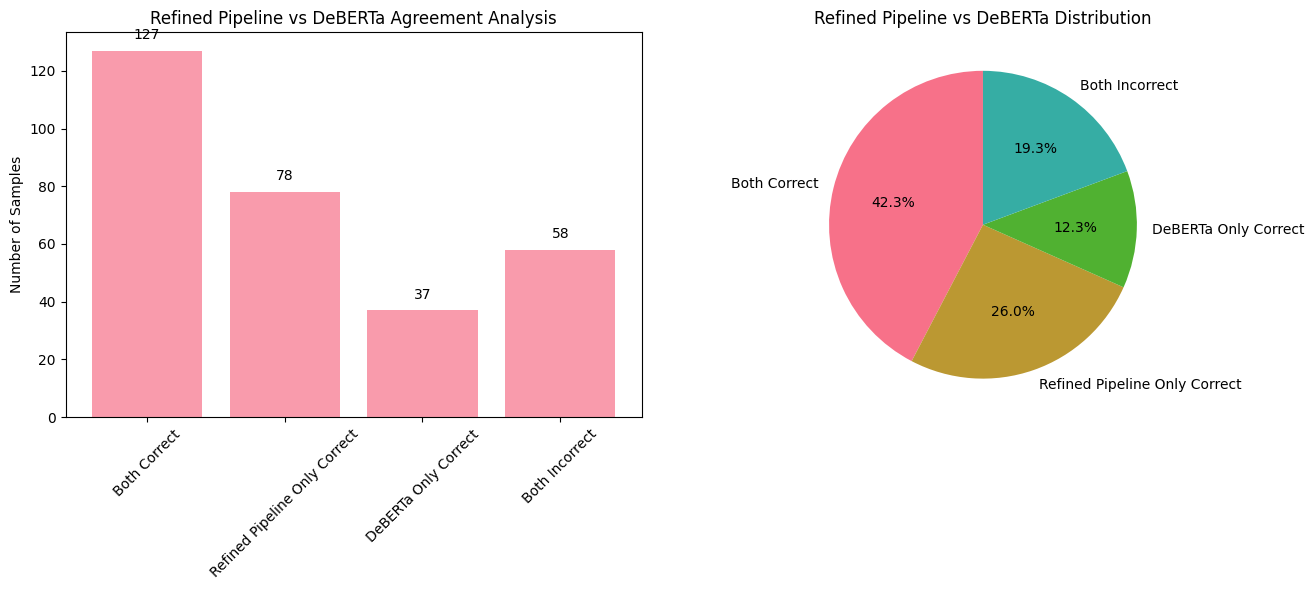


OVERALL AGREEMENT SUMMARY TABLE

Pairwise Agreement Summary:
                       Comparison Both Correct (%) Both Incorrect (%) Total Agreement (%)
                Joint vs Pipeline           63.67%             23.00%              86.67%
           Joint vs Refined Joint           69.33%             30.67%             100.00%
        Joint vs Refined Pipeline           65.00%             27.33%              92.33%
                 Joint vs DeBERTa           44.00%             20.00%              64.00%
        Pipeline vs Refined Joint           63.67%             23.00%              86.67%
     Pipeline vs Refined Pipeline           67.00%             27.33%              94.33%
              Pipeline vs DeBERTa           43.33%             17.33%              60.67%
Refined Joint vs Refined Pipeline           65.00%             27.33%              92.33%
         Refined Joint vs DeBERTa           44.00%             20.00%              64.00%
      Refined Pipeline vs DeBERTa     

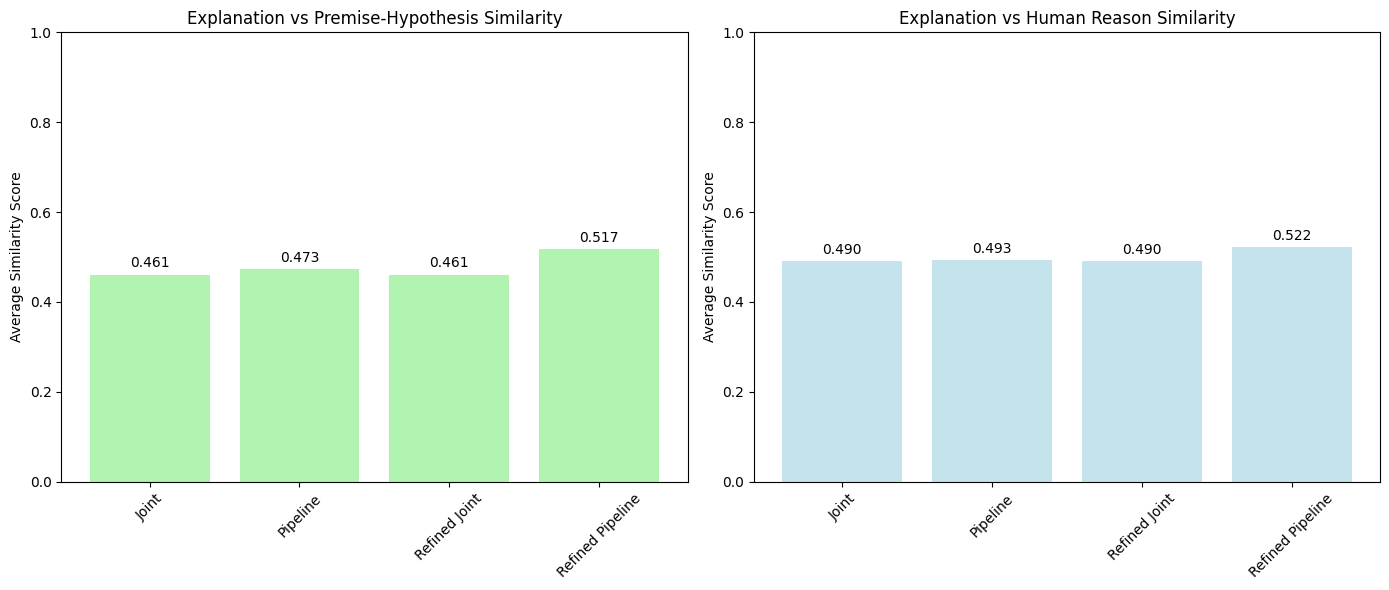


FINAL SUMMARY (ALL MODELS)

Final Performance Summary (All Models):
                  accuracy      f1  precision  recall  num_samples
method                                                            
Joint               0.6933  0.6977     0.7305  0.6933          300
Pipeline            0.7133  0.7164     0.7315  0.7133          300
Refined Joint       0.6933  0.6977     0.7305  0.6933          300
Refined Pipeline    0.6833  0.6879     0.7099  0.6833          300
DeBERTa             0.5467  0.5451     0.5524  0.5467          300

Best performing model: Pipeline with accuracy: 0.7133

Accuracy Ranking:
  1. Pipeline: 0.7133
  2. Joint: 0.6933
  3. Refined Joint: 0.6933
  4. Refined Pipeline: 0.6833
  5. DeBERTa: 0.5467

Explanation Quality Summary (LLM Models Only):
                  avg_pred_vs_premise_hyp  avg_pred_vs_human
method                                                      
Joint                              0.4606             0.4904
Pipeline                           0.4

In [ ]:
# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")


def analyze_and_compare_methods_with_deberta(joint_res, pipeline_res, refined_joint_res, refined_pipeline_res, deberta_preds, ground_truth_labels):
    """Comprehensive analysis and comparison including DeBERTa model."""

    label_to_id, id_to_label = create_label_mapping()
    
    deberta_results = {
        'model_name': 'DeBERTa',
        'predictions': deberta_preds,
        'ground_truth': ground_truth_labels,
        'explanation_qualities': None 
    }
    
    methods_data = {
        'Joint': joint_res,
        'Pipeline': pipeline_res,
        'Refined Joint': refined_joint_res,
        'Refined Pipeline': refined_pipeline_res,
        'DeBERTa': deberta_results
    }
    
    print("Results loaded successfully:")
    for name, data in methods_data.items():
        if data and 'predictions' in data:
            print(f"  {name}: {len(data['predictions'])} predictions")
        else:
            print(f"  {name}: NO DATA")
    
    # 1. CLASSIFICATION PERFORMANCE COMPARISON
    print("\n" + "="*80)
    print("CLASSIFICATION PERFORMANCE COMPARISON (ALL MODELS)")
    print("="*80)
    
    performance_metrics = []
    
    for method_name, results in methods_data.items():
        print(f"\nProcessing {method_name}...")
        
        if not results or not results.get('predictions') or not results.get('ground_truth'):
            print(f"  Skipping {method_name}: empty predictions or ground truth")
            continue
            
        print(f"  Sample predictions: {results['predictions'][:3]}")
        print(f"  Sample ground truth: {results['ground_truth'][:3]}")

        metrics = compute_classification_metrics_safe(results['predictions'], results['ground_truth'])
        
        print(f"  Computed metrics: {metrics}")

        metrics['method'] = method_name
        metrics['num_samples'] = len(results['predictions'])
        
        performance_metrics.append(metrics)
    
    if not performance_metrics:
        print("No valid performance metrics computed")
        return None, None, None
    

    perf_df = pd.DataFrame(performance_metrics)
    perf_df = perf_df.set_index('method')
    
    print("\nPerformance Metrics Summary (All Models):")
    print(perf_df.round(4))
  
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Classification Performance Comparison (Including DeBERTa)', fontsize=16, fontweight='bold')
    
    metrics_to_plot = ['accuracy', 'f1', 'precision', 'recall']
    colors = plt.cm.Set3(np.linspace(0, 1, len(perf_df)))
    
    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx//2, idx%2]
        if metric in perf_df.columns and len(perf_df) > 0:
            bars = ax.bar(perf_df.index, perf_df[metric], alpha=0.8, color=colors)
            ax.set_title(f'{metric.capitalize()} by Method')
            ax.set_ylabel(metric.capitalize())
            ax.tick_params(axis='x', rotation=45)
            ax.set_ylim(0, 1.0)
            
            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                if height > 0:
                    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                           f'{height:.3f}', ha='center', va='bottom')
        else:
            ax.text(0.5, 0.5, f'No data for {metric}', ha='center', va='center', transform=ax.transAxes)
    
    plt.tight_layout()
    plt.show()
    
    # 2. CONFUSION MATRICES COMPARISON (INCLUDING DEBERTA)
    print("\n" + "="*80)
    print("CONFUSION MATRICES COMPARISON (ALL MODELS)")
    print("="*80)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Confusion Matrices: All Methods Including DeBERTa', fontsize=16, fontweight='bold')
    
    labels = ['entailment', 'neutral', 'contradiction']
    
    for idx, (method_name, results) in enumerate(methods_data.items()):
        row = idx // 3
        col = idx % 3
        
        if idx >= 6:  # We only have 6 subplots
            break
            
        ax = axes[row, col] if row < 2 else axes[1, col]
        
        if results and results.get('predictions') and results.get('ground_truth'):
            try:
                norm_pred = normalize_and_convert_labels(results['predictions'], 'string')
                norm_true = normalize_and_convert_labels(results['ground_truth'], 'string')
                cm = confusion_matrix(norm_true, norm_pred, labels=labels)
                cm_normalized = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-10)
                sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
                           xticklabels=labels, yticklabels=labels, ax=ax)
                ax.set_title(f'{method_name}')
                ax.set_xlabel('Predicted')
                ax.set_ylabel('True')
            except Exception as e:
                print(f"Error creating confusion matrix for {method_name}: {e}")
                ax.text(0.5, 0.5, f'Error: {e}', ha='center', va='center', transform=ax.transAxes)
        else:
            ax.text(0.5, 0.5, f'No data for {method_name}', ha='center', va='center', transform=ax.transAxes)
    
    if len(methods_data) == 5:
        axes[1, 2].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # 3. PAIRWISE AGREEMENT ANALYSIS INCLUDING DEBERTA
    print("\n" + "="*80)
    print("PAIRWISE AGREEMENT ANALYSIS (INCLUDING DEBERTA)")
    print("="*80)
    
    def compare_two_models(model1_name, model1_preds, model2_name, model2_preds, ground_truth, plot=True):
        """Compare two models and return agreement statistics."""

        preds1 = normalize_and_convert_labels(model1_preds, 'string')
        preds2 = normalize_and_convert_labels(model2_preds, 'string')
        true_labels = normalize_and_convert_labels(ground_truth, 'string')
        
        # Agreement analysis
        both_correct = sum(1 for p1, p2, t in zip(preds1, preds2, true_labels) 
                          if p1 == t and p2 == t)
        model1_only_correct = sum(1 for p1, p2, t in zip(preds1, preds2, true_labels) 
                                if p1 == t and p2 != t)
        model2_only_correct = sum(1 for p1, p2, t in zip(preds1, preds2, true_labels) 
                                if p1 != t and p2 == t)
        both_incorrect = sum(1 for p1, p2, t in zip(preds1, preds2, true_labels) 
                           if p1 != t and p2 != t)
        
        total = len(true_labels)
        
        agreement_data = {
            'Both Correct': both_correct,
            f'{model1_name} Only Correct': model1_only_correct,
            f'{model2_name} Only Correct': model2_only_correct,
            'Both Incorrect': both_incorrect
        }
        
        print(f"\n{model1_name} vs {model2_name} Agreement Analysis (Total samples: {total}):")
        for category, count in agreement_data.items():
            percentage = (count / total) * 100
            print(f"  {category}: {count} ({percentage:.2f}%)")
        
        if plot:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

            bars = ax1.bar(agreement_data.keys(), agreement_data.values(), alpha=0.7)
            ax1.set_title(f'{model1_name} vs {model2_name} Agreement Analysis')
            ax1.set_ylabel('Number of Samples')
            ax1.tick_params(axis='x', rotation=45)

            for bar in bars:
                height = bar.get_height()
                ax1.text(bar.get_x() + bar.get_width()/2., height + total*0.01, 
                        f'{int(height)}', ha='center', va='bottom')
            
            ax2.pie(agreement_data.values(), labels=agreement_data.keys(), autopct='%1.1f%%', startangle=90)
            ax2.set_title(f'{model1_name} vs {model2_name} Distribution')
            
            plt.tight_layout()
            plt.show()
        
        return agreement_data
    
 
    model_names = list(methods_data.keys())
    agreement_results = {}
    
    for i, model1 in enumerate(model_names):
        for j, model2 in enumerate(model_names):
            if i < j: 
                data1 = methods_data[model1]
                data2 = methods_data[model2]
                
                if (data1 and data1.get('predictions') and 
                    data2 and data2.get('predictions') and
                    len(data1['predictions']) == len(data2['predictions']) == len(data1['ground_truth'])):
                    
                    agreement_data = compare_two_models(
                        model1, data1['predictions'], 
                        model2, data2['predictions'], 
                        data1['ground_truth'], 
                        plot=True
                    )
                    agreement_results[f"{model1}_vs_{model2}"] = agreement_data
    
    # 4. OVERALL AGREEMENT SUMMARY TABLE
    print("\n" + "="*80)
    print("OVERALL AGREEMENT SUMMARY TABLE")
    print("="*80)
    
    if agreement_results:
        # Create a summary table
        summary_data = []
        for comparison, data in agreement_results.items():
            model1, model2 = comparison.replace('_vs_', ' vs ').split(' vs ')
            total_samples = sum(data.values())
            both_correct_pct = (data['Both Correct'] / total_samples) * 100
            both_incorrect_pct = (data['Both Incorrect'] / total_samples) * 100
            
            summary_data.append({
                'Comparison': f"{model1} vs {model2}",
                'Both Correct (%)': f"{both_correct_pct:.2f}%",
                'Both Incorrect (%)': f"{both_incorrect_pct:.2f}%",
                'Total Agreement (%)': f"{(data['Both Correct'] + data['Both Incorrect']) / total_samples * 100:.2f}%"
            })
        
        summary_df = pd.DataFrame(summary_data)
        print("\nPairwise Agreement Summary:")
        print(summary_df.to_string(index=False))
    
    # 5. EXPLANATION QUALITY ANALYSIS (LLM MODELS ONLY)
    print("\n" + "="*80)
    print("EXPLANATION QUALITY ANALYSIS (LLM MODELS ONLY)")
    print("="*80)
    
    explanation_metrics = []
    
    for method_name, results in methods_data.items():
        if method_name != 'DeBERTa' and results and results.get('explanation_qualities'):
            qualities = results['explanation_qualities']
            
            # Calculate average explanation quality metrics
            avg_pred_vs_premise_hyp = np.mean([q['pred_vs_premise_hyp'] for q in qualities if 'pred_vs_premise_hyp' in q])
            avg_pred_vs_human = np.mean([q['pred_vs_human'] for q in qualities if 'pred_vs_human' in q])
            
            explanation_metrics.append({
                'method': method_name,
                'avg_pred_vs_premise_hyp': avg_pred_vs_premise_hyp,
                'avg_pred_vs_human': avg_pred_vs_human
            })
    
    if explanation_metrics:
        exp_df = pd.DataFrame(explanation_metrics)
        exp_df = exp_df.set_index('method')
        
        print("\nExplanation Quality Metrics (LLM Models Only):")
        print(exp_df.round(4))
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        ax1 = axes[0]
        bars1 = ax1.bar(exp_df.index, exp_df['avg_pred_vs_premise_hyp'], alpha=0.7, color='lightgreen')
        ax1.set_title('Explanation vs Premise-Hypothesis Similarity')
        ax1.set_ylabel('Average Similarity Score')
        ax1.tick_params(axis='x', rotation=45)
        ax1.set_ylim(0, 1.0)
        
        for bar in bars1:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom')
        
        ax2 = axes[1]
        bars2 = ax2.bar(exp_df.index, exp_df['avg_pred_vs_human'], alpha=0.7, color='lightblue')
        ax2.set_title('Explanation vs Human Reason Similarity')
        ax2.set_ylabel('Average Similarity Score')
        ax2.tick_params(axis='x', rotation=45)
        ax2.set_ylim(0, 1.0)
        
        for bar in bars2:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
    else:
        exp_df = None
    
    return perf_df, exp_df, agreement_results

# Extract ground truth labels from one of the LLM results
ground_truth_labels = joint_results['ground_truth'] if joint_results else None

# Run the enhanced analysis
print("="*80)
print("RUNNING COMPREHENSIVE ANALYSIS (INCLUDING DEBERTA)")
print("="*80)

performance_df, explanation_df, agreement_analysis = analyze_and_compare_methods_with_deberta(
    joint_results, 
    pipeline_results, 
    refined_joint_results, 
    refined_pipeline_results,
    deberta_predictions,
    ground_truth_labels
)

# Display final summary
print("\n" + "="*80)
print("FINAL SUMMARY (ALL MODELS)")
print("="*80)

if performance_df is not None:
    print("\nFinal Performance Summary (All Models):")
    print(performance_df.round(4))
    
    # Find best performing model
    best_accuracy = performance_df['accuracy'].max()
    best_model = performance_df.loc[performance_df['accuracy'] == best_accuracy].index[0]
    print(f"\nBest performing model: {best_model} with accuracy: {best_accuracy:.4f}")
    
    accuracy_ranking = performance_df.sort_values('accuracy', ascending=False)['accuracy']
    print(f"\nAccuracy Ranking:")
    for i, (model, acc) in enumerate(accuracy_ranking.items()):
        print(f"  {i+1}. {model}: {acc:.4f}")

if explanation_df is not None:
    print("\nExplanation Quality Summary (LLM Models Only):")
    print(explanation_df.round(4))

if agreement_analysis:
    print(f"\nNumber of pairwise comparisons performed: {len(agreement_analysis)}")
    print("See detailed agreement analysis above for specific model comparisons.")

## Results

In [75]:
def print_first_n_results(results_dict, n=5):
    """Print the first n results with all keys in a nicely formatted way."""
    
    if not results_dict or 'results' not in results_dict:
        print("No results found in the dictionary")
        return
    
    results = results_dict['results']
    model_name = results_dict.get('model_name', 'Unknown Model')
    
    print(f"\n{'='*80}")
    print(f"FIRST {n} RESULTS FOR {model_name.upper()}")
    print(f"{'='*80}")
    
    for i in range(min(n, len(results))):
        result = results[i]
        print(f"\n{'-'*60}")
        print(f"SAMPLE {i+1}")
        print(f"{'-'*60}")
        
        for key, value in result.items():
            if isinstance(value, str) and len(value) > 200:
                # Truncate very long strings
                print(f"{key}: {value[:200]}...")
            elif isinstance(value, dict):
                # Handle nested dictionaries (like explanation_quality)
                print(f"{key}:")
                for sub_key, sub_value in value.items():
                    if isinstance(sub_value, float):
                        print(f"  {sub_key}: {sub_value:.4f}")
                    else:
                        print(f"  {sub_key}: {sub_value}")
            elif isinstance(value, float):
                # Format floats to 4 decimal places
                print(f"{key}: {value:.4f}")
            else:
                print(f"{key}: {value}")
    
    print(f"\n{'='*80}")
    print(f"Total samples in {model_name}: {len(results)}")
    print(f"Total predictions: {len(results_dict.get('predictions', []))}")
    print(f"Total ground truth: {len(results_dict.get('ground_truth', []))}")

In [76]:
print_first_n_results(joint_results, 5)


FIRST 5 RESULTS FOR JOINT NLI CLASSIFIER

------------------------------------------------------------
SAMPLE 1
------------------------------------------------------------
premise: one of the orders issued by Ochola in April Login to license this image from 1$. In short At Kira Road police station, the photocopier business has moved behind the station, far away from the prying e...
hypothesis: The decision to move the photocopier business was done for privacy reasons.
true_label: 0
pred_label: entailment
predicted_explanation: The premise explains the relocation of the photocopier business as being positioned away from public view, using the term "prying eyes" to indicate a purpose of shielding it from unwanted observation....
human_reason: I made an obvious inference from the text that a human would understand. This is not something that can be found by literally reading the words on the page.
explanation_quality:
  pred_vs_premise_hyp: 0.5106
  pred_vs_human: 0.3569
  premise_hyp_v

In [77]:
print_first_n_results(pipeline_results, 5)


FIRST 5 RESULTS FOR PIPELINE NLI CLASSIFIER

------------------------------------------------------------
SAMPLE 1
------------------------------------------------------------
premise: one of the orders issued by Ochola in April Login to license this image from 1$. In short At Kira Road police station, the photocopier business has moved behind the station, far away from the prying e...
hypothesis: The decision to move the photocopier business was done for privacy reasons.
true_label: 0
pred_label: entailment
predicted_explanation: The premise and hypothesis are related through the implication of privacy in the description of the business relocation. The phrase "far away from the prying eyes" in the premise indicates an effort t...
human_reason: I made an obvious inference from the text that a human would understand. This is not something that can be found by literally reading the words on the page.
explanation_quality:
  pred_vs_premise_hyp: 0.2314
  pred_vs_human: 0.3998
  premise_hy

In [78]:
print_first_n_results(refined_joint_results, 5)


FIRST 5 RESULTS FOR REFINED JOINT NLI CLASSIFIER

------------------------------------------------------------
SAMPLE 1
------------------------------------------------------------
premise: one of the orders issued by Ochola in April Login to license this image from 1$. In short At Kira Road police station, the photocopier business has moved behind the station, far away from the prying e...
hypothesis: The decision to move the photocopier business was done for privacy reasons.
true_label: 0
pred_label: entailment
predicted_explanation: The premise explains the relocation of the photocopier business as being positioned away from public view, using the term "prying eyes" to indicate a purpose of shielding it from unwanted observation....
human_reason: I made an obvious inference from the text that a human would understand. This is not something that can be found by literally reading the words on the page.
explanation_quality:
  pred_vs_premise_hyp: 0.5106
  pred_vs_human: 0.3569
  premi

In [79]:
print_first_n_results(refined_pipeline_results, 5)


FIRST 5 RESULTS FOR REFINED PIPELINE NLI CLASSIFIER

------------------------------------------------------------
SAMPLE 1
------------------------------------------------------------
premise: one of the orders issued by Ochola in April Login to license this image from 1$. In short At Kira Road police station, the photocopier business has moved behind the station, far away from the prying e...
hypothesis: The decision to move the photocopier business was done for privacy reasons.
true_label: 0
pred_label: entailment
predicted_explanation: The premise explains the relocation of the photocopier business as being positioned away from public view, using the term "prying eyes" to indicate a purpose of shielding it from unwanted observation....
human_reason: I made an obvious inference from the text that a human would understand. This is not something that can be found by literally reading the words on the page.
explanation_quality:
  pred_vs_premise_hyp: 0.5106
  pred_vs_human: 0.3569
  pr

In [93]:
deberta_predictions[:5]

[1, 0, 1, 0, 0]